# Exploratory Data Analysis — Part 2 (Bivariate Analysis)

### Description
This notebook performs **bivariate analysis** to evaluate the relationship between each feature and the **clinical trial outcome** (`overall_status`: Success = 1, Failure = 0).  
It aims to identify statistically significant predictors of trial completion using appropriate tests for both **categorical** and **numerical** variables.

### Key Techniques & Statistical Tests
- **Categorical vs Target:**
  - *Chi-Square Test* → to check independence between feature and outcome  
  - *Cramér’s V* → to measure association strength  
  - *Residual Analysis* → to identify categories deviating from expected proportions  
- **Numerical vs Target:**
  - *Mann-Whitney U Test* → to compare distributions of numeric features across success/failure groups  
  - *Effect Size (r)* → to interpret magnitude of difference  
- **Additional Methods:**
  - *Kruskal-Wallis H Test* for numeric vs multi-category comparisons  
  - *Visualizations:* Side-by-side bar plots, residual heatmaps, and violin/box plots for distributional insights  

### Workflow
1. Load cleaned and merged dataset from EDA_1 output  
2. Define feature groups → numerical, categorical, and binary flags  
3. Conduct statistical significance tests  
4. Visualize associations between features and trial outcomes  
5. Generate result tables and save plots for further analysis  

### Expected Outcome
This step helps identify which features demonstrate **meaningful relationships** with trial outcomes.  
Significant categorical predictors (high Cramér’s V > 0.1) and numerical features (low p-values, large effect sizes) are prioritized for the next phase —  
**EDA_3: Multivariate Interactions Analysis.**

### Outputs
- Tables/plots under: `../results/EDA2_outputs/`
- Final processed dataset → `../data/processed/df_EDA_2.csv`

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

# Paths
DATA_PROCESSED = Path("../data/processed")
RESULTS_DIR = Path("../results/EDA2_outputs")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Utility: safe save figure
def savefig(filename, tight=True, dpi=200, show=True):
    if tight:
        plt.tight_layout()
    filepath = RESULTS_DIR / filename
    plt.savefig(filepath, dpi=dpi)
    if show:
        plt.show()
    plt.close()

In [2]:
# === Helper Function 1: Chi-Square Analysis ===
def chi2_analysis(df, cols, target_col='overall_status', filename=None):
    """
    Perform chi-square tests for categorical and flag columns against a target column.

    Saves summary as <filename> in RESULTS_DIR.
    Returns:
        - results_df: summary dataframe (Chi², p-value, Cramér's V)
        - expected_dict: dict of expected frequency tables for each feature
    """
    results, expected_dict = [], {}

    for col in cols:
        contingency = pd.crosstab(df[col], df[target_col])
        contingency.columns = ['Failure', 'Success']

        chi2_val, p, dof, expected = chi2_contingency(contingency, correction=False)
        n = contingency.sum().sum()
        r, c = contingency.shape
        cramers_v = np.sqrt((chi2_val / n) / min(r - 1, c - 1))

        results.append({
            'Feature': col,
            'Chi2': round(chi2_val, 2),
            'p_value': round(p, 4),
            'Cramers_v': round(cramers_v, 3)
        })

        expected_dict[col] = pd.DataFrame(expected, index=contingency.index, columns=contingency.columns)

    results_df = pd.DataFrame(results)
    results_df.to_csv(RESULTS_DIR / filename, index=False)
    print("Chi-square summary:")
    display(results_df)

    return results_df, expected_dict


# === Helper Function 2: Categorical Feature Stats ===
def categorical_feature_stats(df, col, expected_dict, target_col='overall_status',
                              xlabel=None, title=None, figsize=(12, 6),
                              rotate_ticks=False, show=False):
    """
    Generate detailed summary + plots for a categorical feature vs target.

    Saves:
    - {col}_summary.csv → RESULTS_DIR
    - {col}_residuals.png → RESULTS_DIR
    - {col}_barplot.png → RESULTS_DIR
    """
    # Contingency table
    contingency = pd.crosstab(df[col], df[target_col])
    contingency.columns = ['Failure', 'Success']
    contingency['Total'] = contingency.sum(axis=1)
    contingency['Success_rate'] = (contingency['Success'] / contingency['Total'] * 100).round(2)
    contingency['Failure_rate'] = (contingency['Failure'] / contingency['Total'] * 100).round(2)

    # Residuals
    expected_df = expected_dict[col].round(2)
    residuals = ((contingency[['Failure', 'Success']] - expected_df) / np.sqrt(expected_df)).round(2)
    expected_df.columns = ['Expected_Failure', 'Expected_Success']
    residuals.columns = ['Residual_Failure', 'Residual_Success']

    # Summary table
    summary = pd.concat(
        [contingency.reset_index(), expected_df.reset_index(drop=True), residuals.reset_index(drop=True)],
        axis=1
    )
    table_path = RESULTS_DIR / f"{col}_vs_{target_col}_summary.csv"
    summary.to_csv(table_path, index=False)
    if show:
        print(f"{col}_vs_{target_col}_summary:")
        display(summary)

    # Residual heatmap
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(residuals, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel(col, fontsize=12, fontweight='bold')
    plt.title(f"Chi² Residuals: {col} vs {target_col}", fontsize=14, fontweight='bold')
    plt.yticks(rotation=0)
    savefig(f"{col}_residuals.png", show=show)

    # Barplot
    melted = summary.melt(id_vars=col,
                          value_vars=['Success', 'Failure'],
                          var_name='Outcome',
                          value_name='Count')

    plt.figure(figsize=figsize)
    ax = sns.barplot(data=melted, x=col, y='Count', hue='Outcome',
                     palette={'Failure': 'salmon', 'Success': 'skyblue'})

    if rotate_ticks:
        plt.xticks(rotation=45, ha='right')

    # Annotate each bar with percentage
    for i, p in enumerate(ax.patches):
        count = int(p.get_height())
        if count == 0:
            continue
        category_name = melted.iloc[i][col]
        category_total = summary.loc[summary[col] == category_name, 'Total'].values[0]
        pct = 100 * count / category_total
        ax.annotate(f'{pct:.1f}%',
                    (p.get_x() + p.get_width() / 2, count + max(category_total * 0.01, 50)),
                    ha='center', va='bottom', fontsize=9)

    plt.title(title if title else f"Distribution of {col} vs {target_col}", fontsize=14, fontweight='bold')
    plt.xlabel(xlabel if xlabel else col, fontsize=12, fontweight='bold')
    plt.ylabel('Number of Trials', fontsize=12, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    savefig(f"{col}_vs_{target_col}_barplot.png", show=show)


# === Helper Function 3: Flag/Ternary Columns ===
def plot_flag_columns(df, flag_col, target_col='overall_status', show=False):
    """
    Plot barplot of ternary/binary flag column vs target.
    Saves one plot per flag column into RESULTS_DIR.
    """
    hue_order = sorted(df[target_col].unique())

    plt.figure(figsize=(8, 6))
    ax = sns.countplot(
        data=df, x=flag_col, hue=target_col,
        hue_order=hue_order,
        palette={0: 'salmon', 1: 'skyblue'}
    )
    ax.set_title(f"{flag_col} vs {target_col}", fontsize=12, fontweight='bold')
    ax.set_xlabel(flag_col, fontsize=10, fontweight='bold')
    ax.set_ylabel('Number of Trials', fontsize=10, fontweight='bold')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    # Annotate percentages
    # get the two Bar Containers (one per hue)
    bars_fail, bars_succ = ax.containers[:2]

    for k in range(len(bars_fail.patches)):
        b0 = bars_fail.patches[k]   
        b1 = bars_succ.patches[k]   
        h0 = b0.get_height()
        h1 = b1.get_height()
        total = h0 + h1
        if total == 0:
            continue
        p0 = 100 * h0 / total
        p1 = 100 * h1 / total

        ax.annotate(f'{p0:.1f}%', 
                    (b0.get_x() + b0.get_width()/2, h0 + 1000),
                    ha = 'center', va = 'bottom', fontsize = 9)
        ax.annotate(f'{p1:.1f}%', 
                    (b1.get_x() + b1.get_width()/2, h1 + 1000),
                    ha = 'center', va = 'bottom', fontsize = 9)

    savefig(f"{flag_col}_vs_{target_col}.png", show=show)


In [3]:
# Load dataset
df_EDA_2 = pd.read_csv(DATA_PROCESSED / "df_EDA_1.csv")

print("✅ Loaded dataset")
print("Shape:", df_EDA_2.shape)

✅ Loaded dataset
Shape: (263136, 81)


In [4]:
# Converts one-hot encoded columns with a shared prefix into a single categorical column
def merge_onehot_prefix(df, new_col, prefix, exclude = None):
    cols = [c for c in df.columns if c.startswith(prefix)]
    if exclude:
        cols = [c for c in cols if c not in exclude]
    
    df[cols] = df[cols].fillna(0).astype(float)
    df[new_col] = df[cols].idxmax(axis = 1).str.replace(prefix, "", regex = False)

    # if all the values are zeros in a row, set as 'None'
    df.loc[df[cols].sum(axis = 1) == 0, new_col] = "None"

    # if more than 1, mark as 'Multiple'
    df.loc[df[cols].sum(axis = 1) > 1, new_col] = "Multiple"

In [5]:
# Apply transformation to various one-hot groups
merge_onehot_prefix(df_EDA_2, new_col = 'phase_grouped', prefix = 'phase_')
merge_onehot_prefix(df_EDA_2, new_col = 'intervention_grouped', prefix = 'intervention_', exclude = ['intervention_count'])
merge_onehot_prefix(df_EDA_2, new_col = 'condt_grouped', prefix = 'condt_')
merge_onehot_prefix(df_EDA_2, new_col = 'allocation_grouped', prefix = 'allocation_')
merge_onehot_prefix(df_EDA_2, new_col = 'masking_grouped', prefix = 'masking_')
merge_onehot_prefix(df_EDA_2, new_col = 'model_grouped', prefix = 'model_')
merge_onehot_prefix(df_EDA_2, new_col = 'purpose_grouped', prefix = 'purpose_')
merge_onehot_prefix(df_EDA_2, new_col = 'sponsor_grouped', prefix = 'sponsor_')
merge_onehot_prefix(df_EDA_2, new_col = 'elig_gender_grouped', prefix = 'elig_gender_')
merge_onehot_prefix(df_EDA_2, new_col = 'elig_age_grouped', prefix = 'elig_age_')

In [6]:
# Analyze enrollment distribution and flag high-enrollment outliers by trial phase

# Define phase one-hot encoded columns
phase_cols = ['phase_1', 'phase_2', 'phase_3', 'phase_4', 'phase_not applicable']

cutoff_975, cutoff_99, phase_enroll_summary = {}, {}, []

# Calculate thresholds and summary stats for each phase
for col in phase_cols:
    phase_data = df_EDA_2.loc[df_EDA_2[col] == 1, 'enrollment']

    # Percentile cutoffs
    cutoff_975[col] = phase_data.quantile(0.975)
    cutoff_99[col] = phase_data.quantile(0.99)

    # Counts above thresholds
    above_975 = (phase_data > cutoff_975[col]).sum()
    above_99 = (phase_data > cutoff_99[col]).sum()

    # Append to summary
    phase_enroll_summary.append({
        'Phase': col,
        'Total_count': phase_data.shape[0],
        '97.5 percentile': round(cutoff_975[col], 2),
        'count > 97.5': above_975,
        '99 percentile': round(cutoff_99[col], 2),
        'count > 99': above_99
    })

# Create summary DataFrame and save the table
phase_enroll_summary_df = pd.DataFrame(phase_enroll_summary)
display(phase_enroll_summary_df)
phase_enroll_summary_df.to_csv(DATA_PROCESSED / "df_phase_enroll_summary.csv")

# Add flags for high enrollment trials
df_EDA_2['high_enroll_flag_975'] = 0
df_EDA_2['high_enroll_flag_99'] = 0

for col in phase_cols:
    df_EDA_2.loc[(df_EDA_2[col] == 1) & (df_EDA_2['enrollment'] > cutoff_975[col]), 'high_enroll_flag_975'] = 1
    df_EDA_2.loc[(df_EDA_2[col] == 1) & (df_EDA_2['enrollment'] > cutoff_99[col]), 'high_enroll_flag_99'] = 1

# Print counts of flagged trials
print("Total trials flagged above 97.5 percentile:", df_EDA_2['high_enroll_flag_975'].sum())
print("Total trials flagged above 99 percentile:", df_EDA_2['high_enroll_flag_99'].sum())


,Phase,Total_count,97.5 percentile,count > 97.5,99 percentile,count > 99
0,phase_1,42505,168.00,1053,287.96,426
1,phase_2,44866,503.00,1121,823.35,449
2,phase_3,29130,3197.55,729,7434.48,292
3,phase_4,23111,1469.25,578,4000.00,229
4,phase_not applicable,123524,1503.00,3088,4729.93,1236


Total trials flagged above 97.5 percentile: 6569
Total trials flagged above 99 percentile: 2632


In [7]:
# Define categorical features
cat_cols = [
    'phase_grouped', 'intervention_grouped', 'condt_grouped',
    'allocation_grouped', 'masking_grouped', 'model_grouped',
    'purpose_grouped', 'sponsor_grouped', 'elig_age_grouped', 'elig_gender_grouped'
]

# Run chi-square on cat_cols
chi2_summary, expected_dict = chi2_analysis(df_EDA_2, cat_cols, filename="chi2_summary_cat_cols.csv")

Chi-square summary:


,Feature,Chi2,p_value,Cramers_v
0,phase_grouped,3500.07,0.0,0.115
1,intervention_grouped,4597.89,0.0,0.132
2,condt_grouped,5158.68,0.0,0.140
3,allocation_grouped,1924.25,0.0,0.086
4,masking_grouped,1778.10,0.0,0.082
5,model_grouped,2809.22,0.0,0.103
6,purpose_grouped,2164.30,0.0,0.091
7,sponsor_grouped,117.93,0.0,0.021
8,elig_age_grouped,411.46,0.0,0.040
9,elig_gender_grouped,243.62,0.0,0.030


phase_grouped_vs_overall_status_summary:


,phase_grouped,Failure,Success,Total,Success_rate,Failure_rate,Expected_Failure,Expected_Success,Residual_Failure,Residual_Success
0,1,7308,35197,42505,82.81,17.19,6152.61,36352.39,14.73,-6.06
1,2,9636,35230,44866,78.52,21.48,6494.36,38371.64,38.98,-16.04
2,3,4254,24876,29130,85.40,14.60,4216.57,24913.43,0.58,-0.24
3,4,3685,19426,23111,84.06,15.94,3345.32,19765.68,5.87,-2.42
4,not applicable,13206,110318,123524,89.31,10.69,17880.13,105643.87,-34.96,14.38


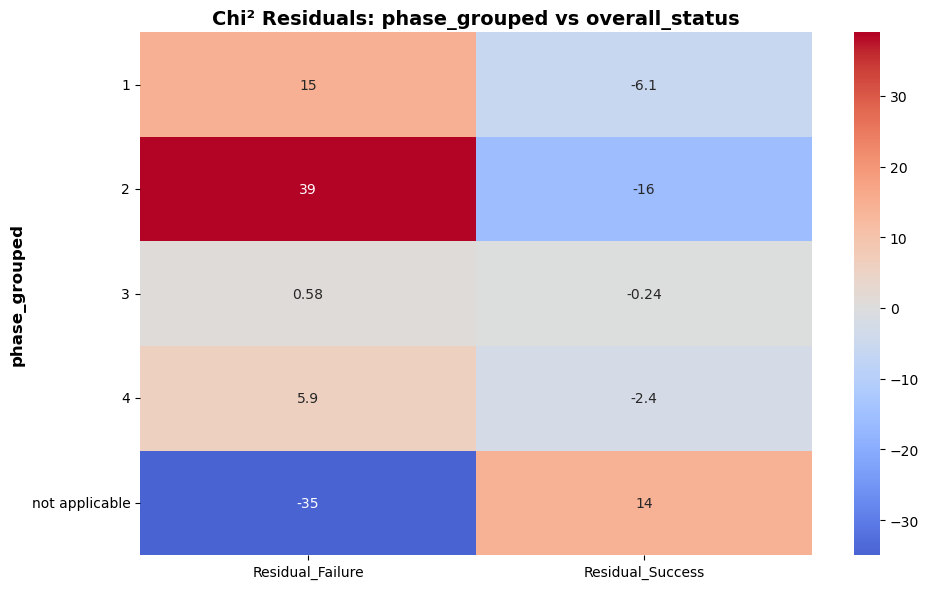

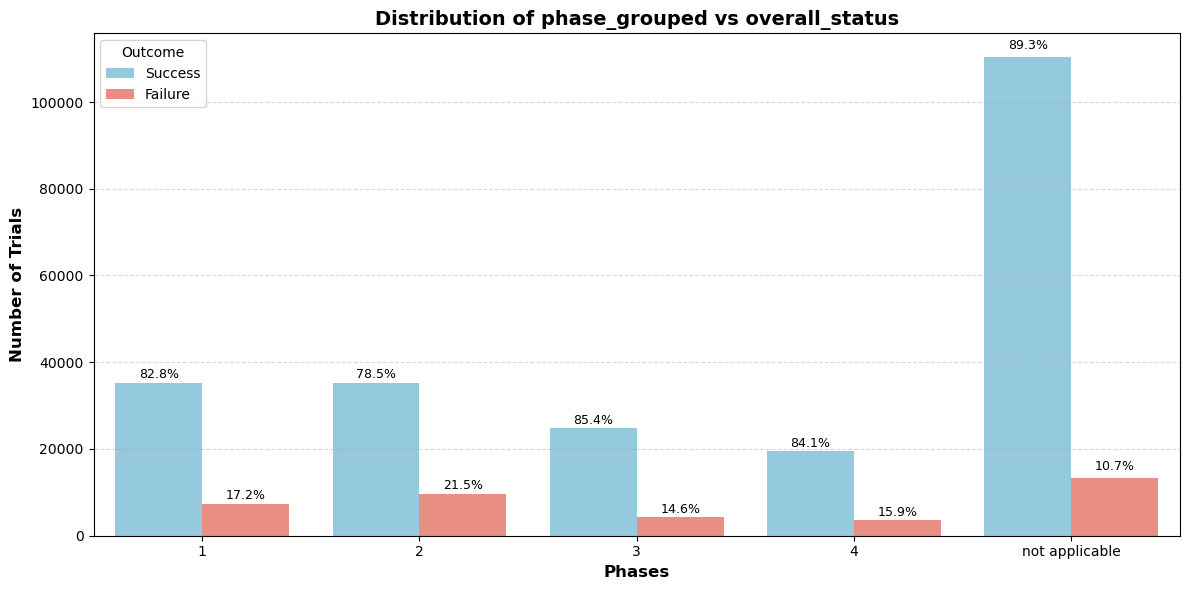

In [8]:
categorical_feature_stats(df_EDA_2, 'phase_grouped', expected_dict, xlabel = 'Phases', show=True)

intervention_grouped_vs_overall_status_summary:


,intervention_grouped,Failure,Success,Total,Success_rate,Failure_rate,Expected_Failure,Expected_Success,Residual_Failure,Residual_Success
0,Multiple,6743,27721,34464,80.43,19.57,4988.67,29475.33,24.84,-10.22
1,behavioral,1798,26382,28180,93.62,6.38,4079.06,24100.94,-35.72,14.69
2,biological,1446,8743,10189,85.81,14.19,1474.86,8714.14,-0.75,0.31
3,combination_product,107,583,690,84.49,15.51,99.88,590.12,0.71,-0.29
4,device,4299,22477,26776,83.94,16.06,3875.83,22900.17,6.80,-2.80
5,diagnostic_test,262,1854,2116,87.62,12.38,306.29,1809.71,-2.53,1.04
6,dietary_supplement,546,7413,7959,93.14,6.86,1152.07,6806.93,-17.86,7.35
7,drug,17924,85018,102942,82.59,17.41,14900.88,88041.12,24.77,-10.19
8,genetic,69,271,340,79.71,20.29,49.22,290.78,2.82,-1.16
9,other,2636,29982,32618,91.92,8.08,4721.46,27896.54,-30.35,12.49


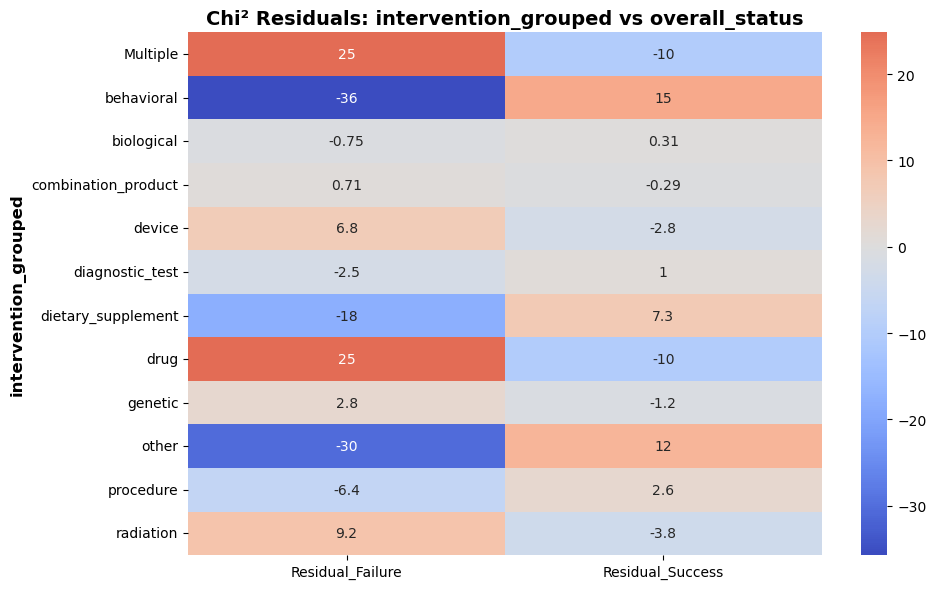

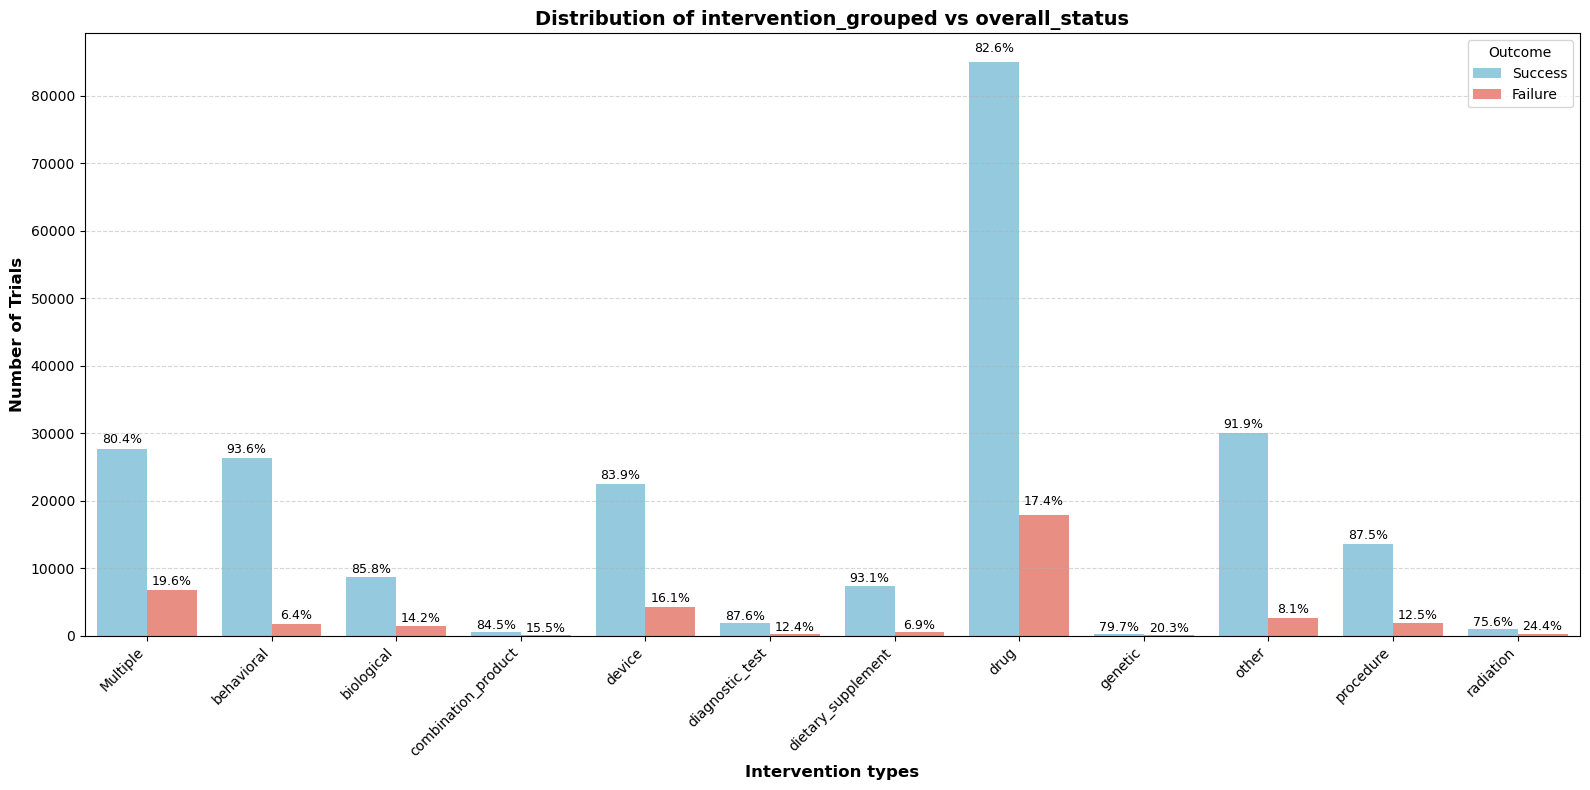

In [9]:
categorical_feature_stats(df_EDA_2, 'intervention_grouped', expected_dict, xlabel = 'Intervention types',
                          figsize = (16, 8), rotate_ticks = True, show=True)

condt_grouped_vs_overall_status_summary:


,condt_grouped,Failure,Success,Total,Success_rate,Failure_rate,Expected_Failure,Expected_Success,Residual_Failure,Residual_Success
0,Multiple,6721,38905,45626,85.27,14.73,6604.37,39021.63,1.44,-0.59
1,None,445,8971,9416,95.27,4.73,1362.97,8053.03,-24.86,10.23
2,cancers,9274,27449,36723,74.75,25.25,5315.66,31407.34,54.29,-22.34
3,cardiovascular_diseases,2090,11500,13590,84.62,15.38,1967.16,11622.84,2.77,-1.14
4,dental_disorders,95,1995,2090,95.45,4.55,302.53,1787.47,-11.93,4.91
5,dermatological_disorders,480,3560,4040,88.12,11.88,584.79,3455.21,-4.33,1.78
6,endocrine/metabolic_disorders,1226,11688,12914,90.51,9.49,1869.30,11044.70,-14.88,6.12
7,gastrointestinal_disorders,1300,6462,7762,83.25,16.75,1123.55,6638.45,5.26,-2.17
8,genetic_disorders,37,160,197,81.22,18.78,28.52,168.48,1.59,-0.65
9,infectious_diseases,1521,9788,11309,86.55,13.45,1636.98,9672.02,-2.87,1.18


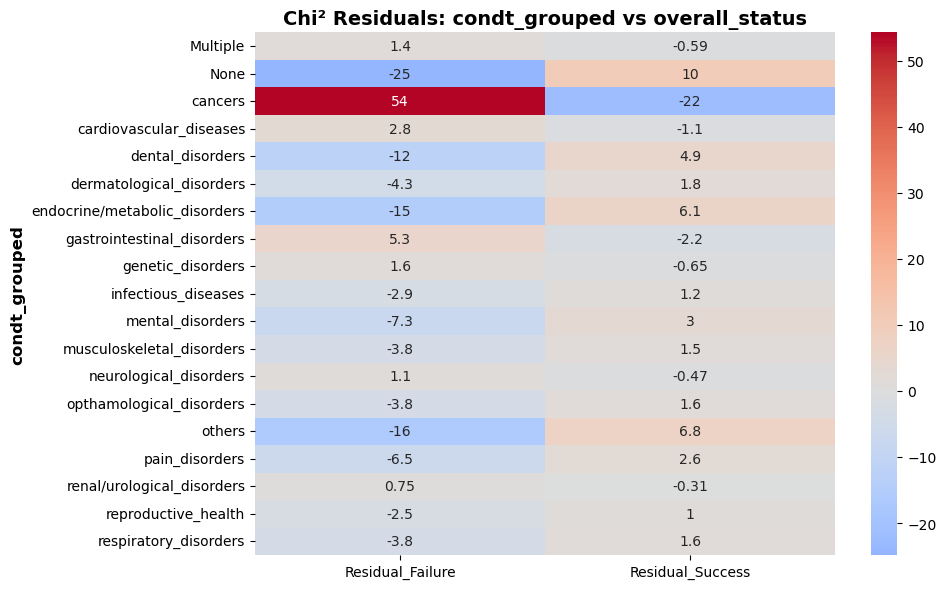

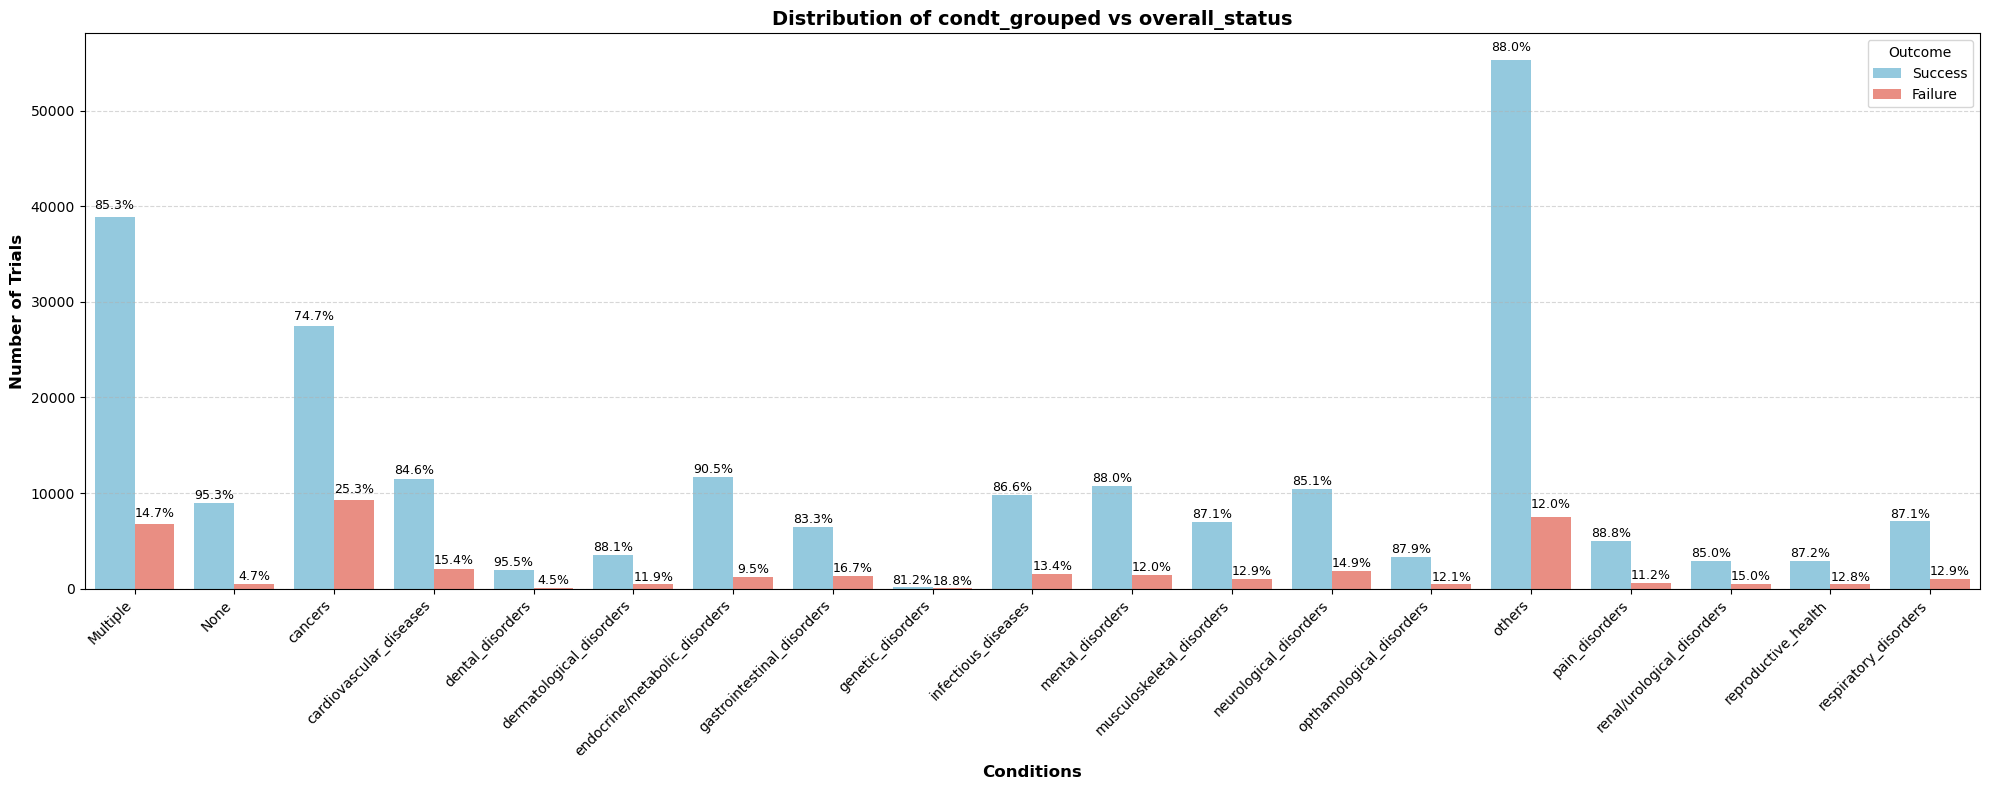

In [10]:
categorical_feature_stats(df_EDA_2, 'condt_grouped', expected_dict, xlabel = 'Conditions', 
                          figsize = (20, 8), rotate_ticks = True, show = True)

model_grouped_vs_overall_status_summary:


,model_grouped,Failure,Success,Total,Success_rate,Failure_rate,Expected_Failure,Expected_Success,Residual_Failure,Residual_Success
0,None,819,4972,5791,85.86,14.14,838.25,4952.75,-0.66,0.27
1,crossover,1983,23112,25095,92.10,7.90,3632.51,21462.49,-27.37,11.26
2,factorial,362,3468,3830,90.55,9.45,554.39,3275.61,-8.17,3.36
3,parallel,20706,133610,154316,86.58,13.42,22337.28,131978.72,-10.91,4.49
4,sequential,1349,4460,5809,76.78,23.22,840.85,4968.15,17.52,-7.21
5,single_group,12596,52432,65028,80.63,19.37,9412.82,55615.18,32.81,-13.50
6,unknown,274,2993,3267,91.61,8.39,472.90,2794.10,-9.15,3.76


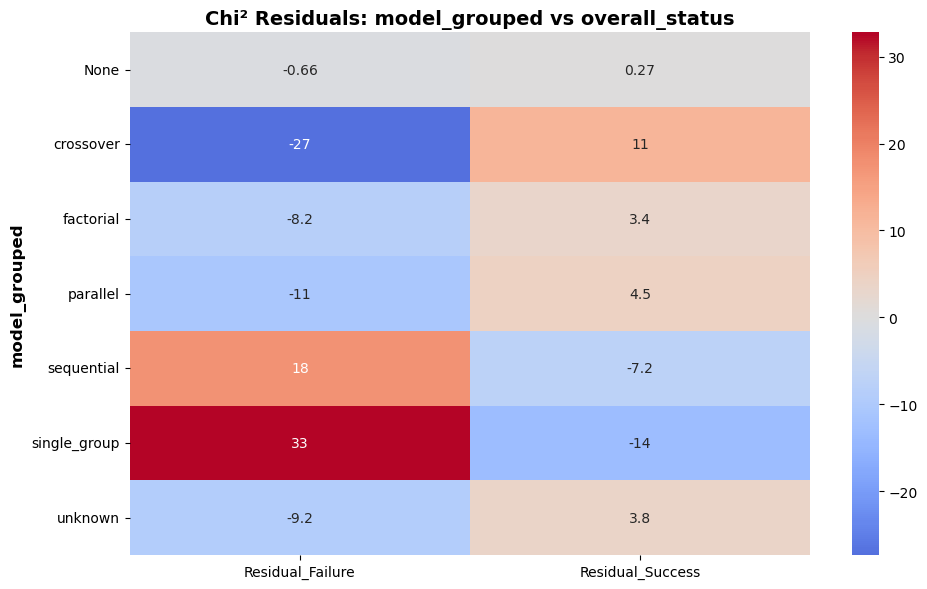

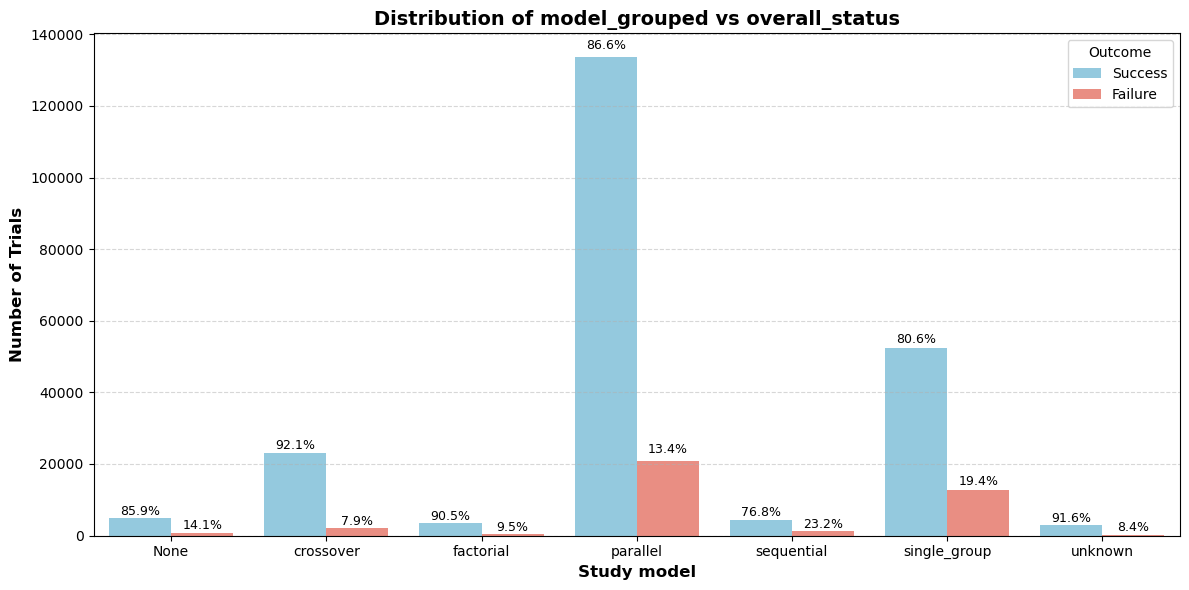

In [11]:
categorical_feature_stats(df_EDA_2, 'model_grouped', expected_dict, xlabel = 'Study model', show=True)

In [12]:
categorical_feature_stats(df_EDA_2, 'allocation_grouped', expected_dict, xlabel = 'Allocation methods')
categorical_feature_stats(df_EDA_2, 'purpose_grouped', expected_dict, xlabel = 'Study purpose')
categorical_feature_stats(df_EDA_2, 'masking_grouped', expected_dict, xlabel = 'Masking methods')
categorical_feature_stats(df_EDA_2, 'sponsor_grouped', expected_dict, xlabel = 'Sponsor')
categorical_feature_stats(df_EDA_2, 'elig_age_grouped', expected_dict, xlabel = 'Age')
categorical_feature_stats(df_EDA_2, 'elig_gender_grouped', expected_dict, xlabel = 'Gender')

In [13]:
# Run chi-square summary on ternary/flag variables (-1, 0, 1)
flag_cols = ['has_dmc', 'has_expanded_access','is_fda_regulated_drug', 'is_fda_regulated_device', 'healthy_volunteers']
chi2_summary, expected_dict = chi2_analysis(df_EDA_2, flag_cols, filename='chi2_summary_flag_cols.csv')

Chi-square summary:


,Feature,Chi2,p_value,Cramers_v
0,has_dmc,1428.05,0.0,0.074
1,has_expanded_access,224.68,0.0,0.029
2,is_fda_regulated_drug,5442.23,0.0,0.144
3,is_fda_regulated_device,751.86,0.0,0.053
4,healthy_volunteers,4401.38,0.0,0.129


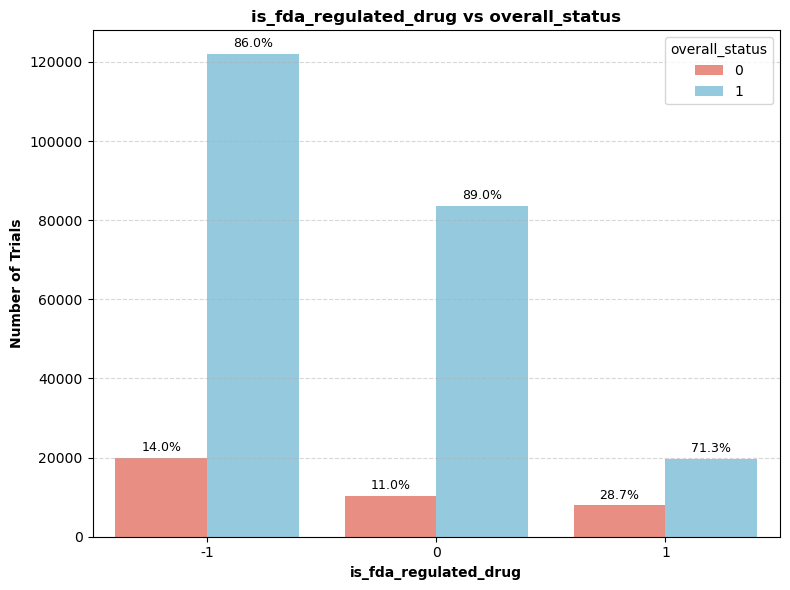

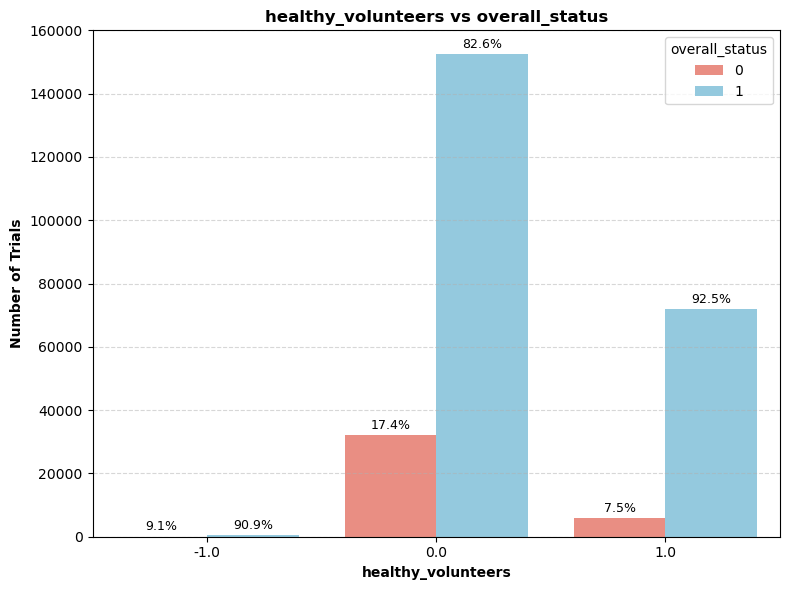

In [14]:
plot_flag_columns(df_EDA_2,'is_fda_regulated_drug', show=True)
plot_flag_columns(df_EDA_2, 'healthy_volunteers', show=True)

flag_cols = ['has_dmc', 'has_expanded_access', 'is_fda_regulated_device']
for col in flag_cols:
    plot_flag_columns(df_EDA_2, col)


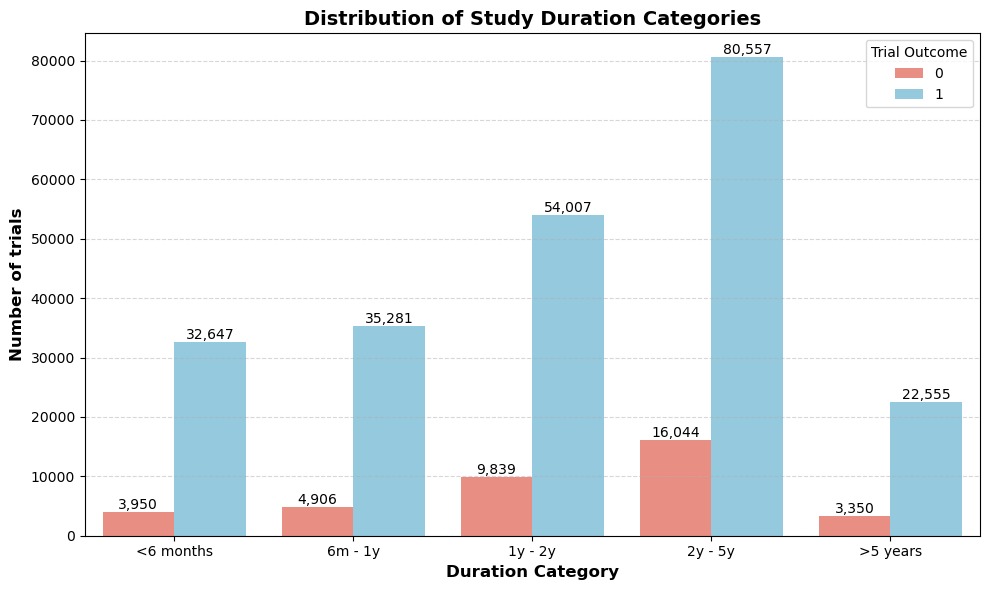

In [15]:
# Categorize study durations into bins and plot distribution vs trial outcomes

# Define bins (in days) and labels
bins = [-1, 180, 365, 730, 2000, float('inf')]
bin_labels = ['<6 months', '6m - 1y', '1y - 2y', '2y - 5y', '>5 years']

# Create duration bins
df_EDA_2['duration_bins'] = pd.cut(
    df_EDA_2['duration_of_study'],
    bins=bins,
    labels=bin_labels,
    right=False,
    include_lowest=True
)

# Custom colors (0 = Failure, 1 = Success)
custom_colors = {0: 'salmon', 1: 'skyblue'}

# Plot distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df_EDA_2, x='duration_bins', hue='overall_status',
    palette=custom_colors, legend=True
)

plt.title('Distribution of Study Duration Categories', fontsize=14, fontweight='bold')
plt.xlabel('Duration Category', fontsize=12, fontweight='bold')
plt.ylabel('Number of trials', fontsize=12, fontweight='bold')
plt.grid(True, axis='y', linestyle="--", alpha=0.5)

# Annotate counts on bars
for p in ax.patches:
    count = int(p.get_height())
    if count > 0:
        ax.annotate(f'{count:,}',
                    (p.get_x() + p.get_width()/2, count),
                    ha='center', va='bottom', fontsize=10)

plt.legend(title='Trial Outcome')
savefig('study_duration_bins_dist.png')


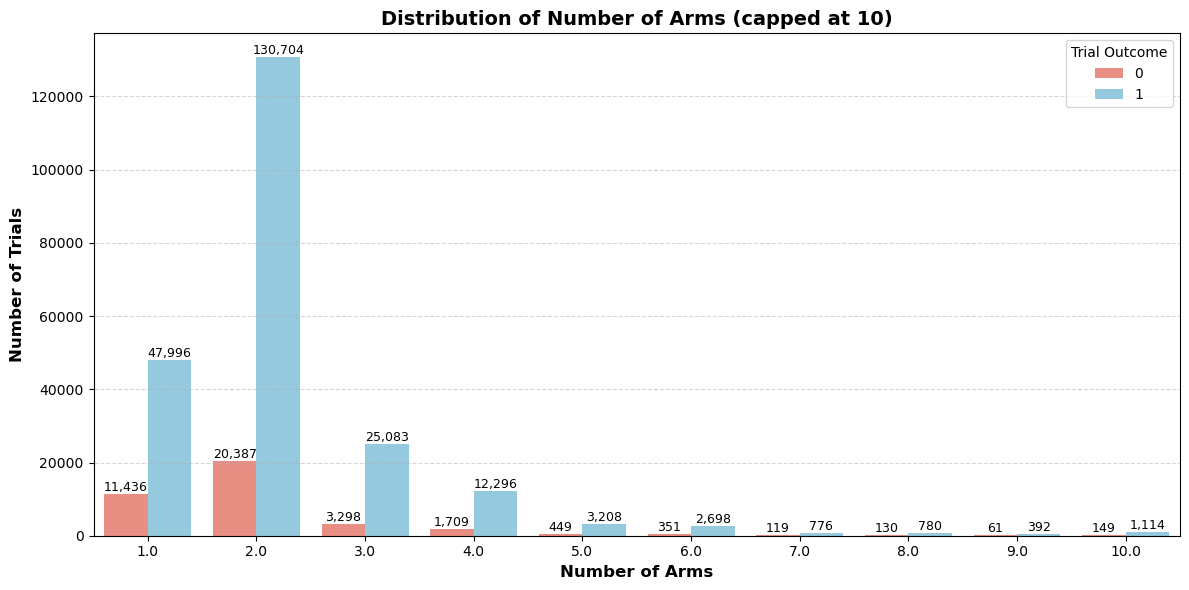

In [16]:
# Cap number of arms to a maximum of 10 and plot distribution vs trial outcomes

# Cap the number of arms (values > 10 grouped into category "10")
df_EDA_2['arms_capped'] = df_EDA_2['number_of_arms'].apply(lambda x: x if x <= 10 else 10)

# Custom colors (0 = Failure, 1 = Success)
custom_colors = {0: 'salmon', 1: 'skyblue'}

# Plot distribution of arms_capped vs outcome
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df_EDA_2, x='arms_capped', hue='overall_status',
    palette=custom_colors, legend=True
)

plt.title('Distribution of Number of Arms (capped at 10)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Arms', fontsize=12, fontweight='bold')
plt.ylabel('Number of Trials', fontsize=12, fontweight='bold')
plt.grid(True, axis='y', linestyle="--", alpha=0.5)

# Annotate counts on bars
for p in ax.patches:
    count = int(p.get_height())
    if count > 0:
        ax.annotate(f'{count:,}',
                    (p.get_x() + p.get_width()/2, count),
                    ha='center', va='bottom', fontsize=9)

plt.legend(title='Trial Outcome')
savefig("number_of_arms_dist.png")


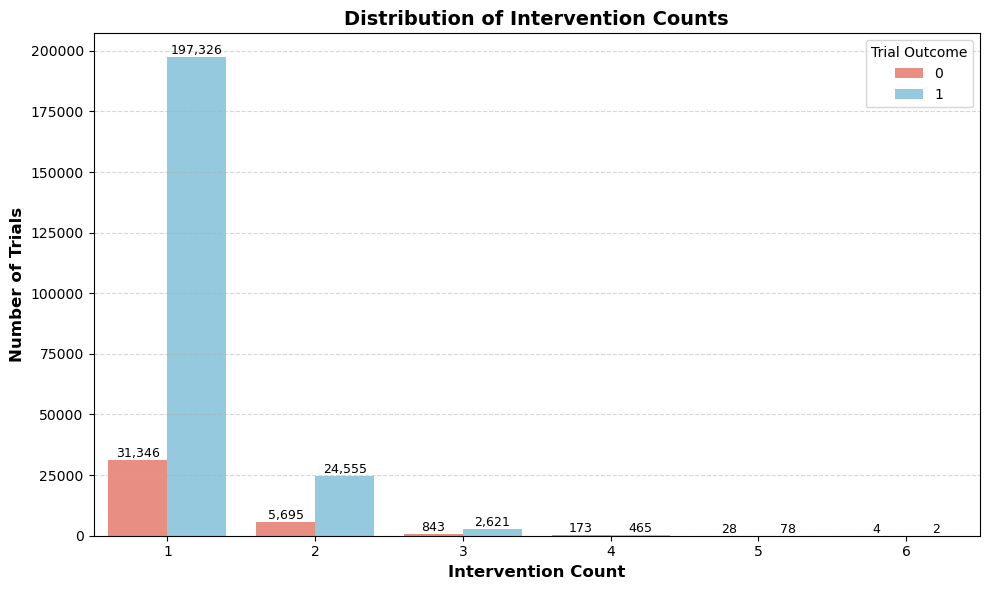

In [17]:
# Visualize trial completion status across intervention counts

# Custom colors (0 = Failure, 1 = Success)
custom_colors = {0: 'salmon', 1: 'skyblue'}

plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=df_EDA_2, x='intervention_count', hue='overall_status',
    palette=custom_colors, legend=True
)

plt.title('Distribution of Intervention Counts', fontsize=14, fontweight='bold')
plt.xlabel('Intervention Count', fontsize=12, fontweight='bold')
plt.ylabel('Number of Trials', fontsize=12, fontweight='bold')
plt.grid(True, axis='y', linestyle="--", alpha=0.5)

# Annotate counts on bars
for p in ax.patches:
    count = int(p.get_height())
    if count > 0:
        ax.annotate(f'{count:,}',
                    (p.get_x() + p.get_width()/2, count),
                    ha='center', va='bottom', fontsize=9)

plt.legend(title='Trial Outcome')
savefig("intervention_counts_dist.png")

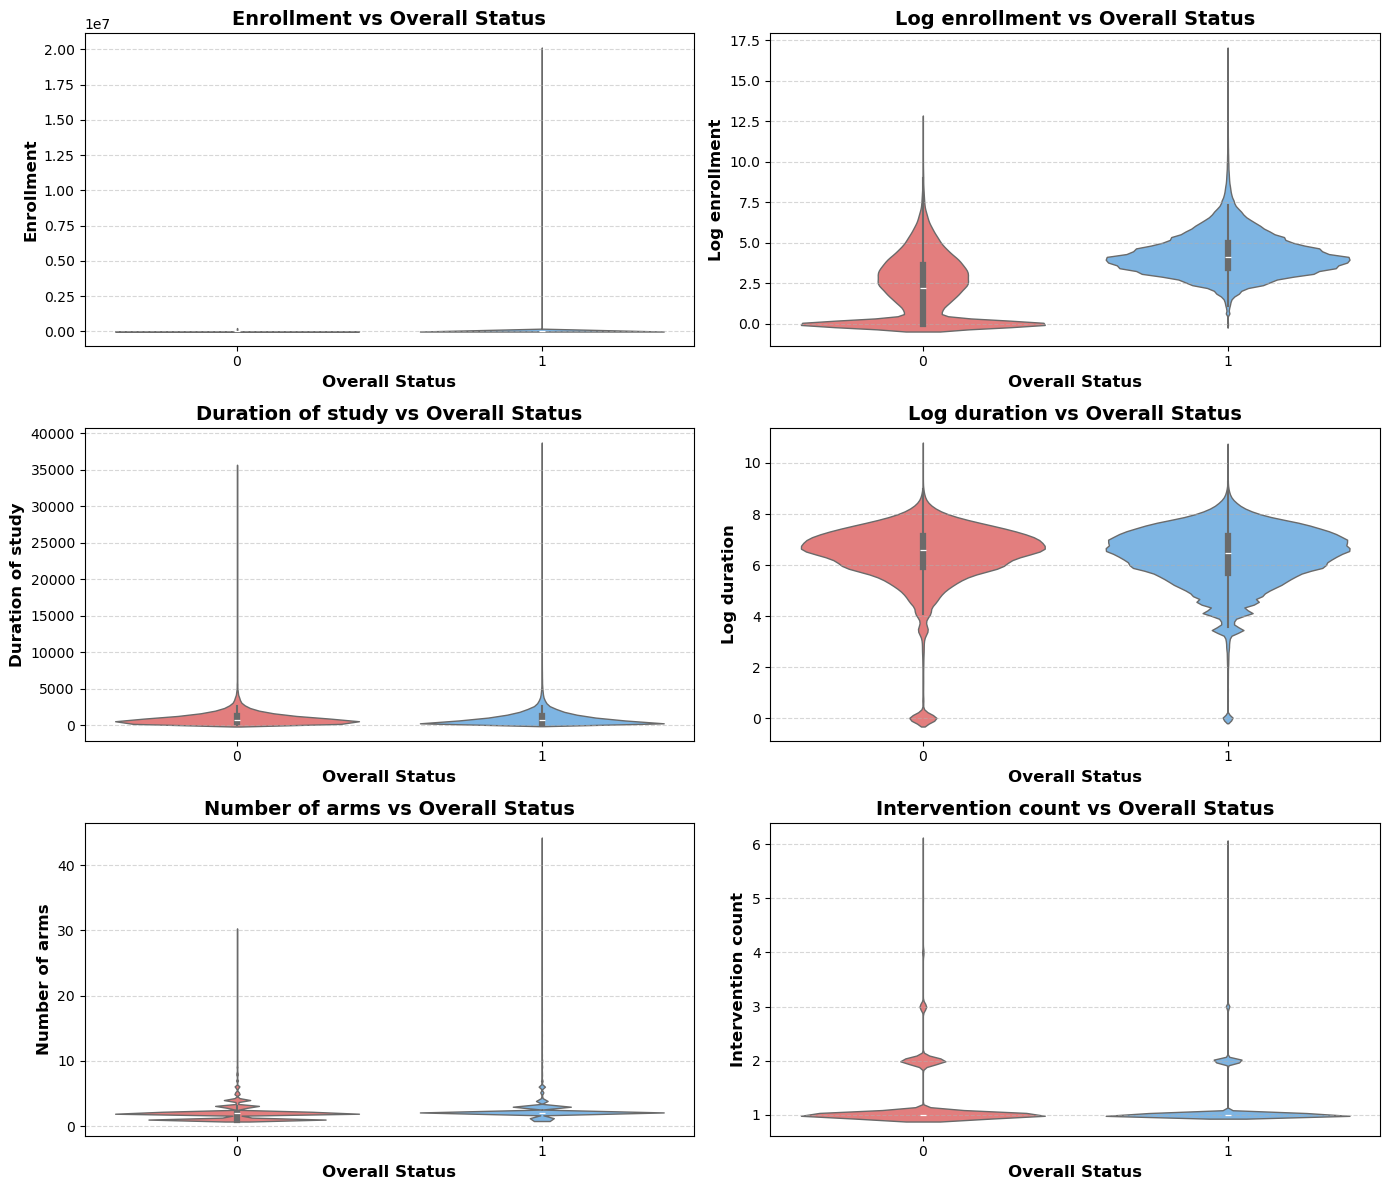

In [18]:
# violin plots for numerical columns vs trial outcome

numerical_cols = [
    'enrollment', 'log_enrollment',
    'duration_of_study', 'log_duration',
    'number_of_arms', 'intervention_count'
]

# Create subplot grid (3 rows x 2 cols)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.violinplot(
        data=df_EDA_2, x='overall_status', y=col, hue='overall_status',
        palette={0: '#F46D6D', 1: '#6DB7F4'},
        inner='box', linewidth=1, legend=False, ax=axes[i]
    )
    axes[i].set_title(f"{col.replace('_', ' ').capitalize()} vs Overall Status",
                      fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Overall Status', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(col.replace('_', ' ').capitalize(), fontsize=12, fontweight='bold')
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
savefig("num_cols_vs_overall.png", show=True)

In [19]:
# Mann-Whitney U test between numerical features and overall status

results = []
for col in numerical_cols:
    # Split data by outcome
    x = df_EDA_2.loc[df_EDA_2['overall_status'] == 0, col]  # Failures
    y = df_EDA_2.loc[df_EDA_2['overall_status'] == 1, col]  # Successes
    
    # Run Mann-Whitney U test
    U, p = mannwhitneyu(x, y, alternative='two-sided')

    n0, n1 = len(x), len(y)

    # Mean and standard deviation of U under null hypothesis
    mean_u = n0 * n1 / 2
    std_u = np.sqrt(n0 * n1 * (n0 + n1 + 1) / 12)

    # Z-score and effect size (r)
    z_score = (U - mean_u) / std_u
    r = abs(z_score) / np.sqrt(n0 + n1)

    # Collect results
    results.append({
        'Feature': col,
        'Failure_total': n0,
        'Success_total': n1,
        'Failure_median': np.median(x).round(2),
        'Success_median': np.median(y).round(2),
        'IQR_failure': (np.percentile(x, 75) - np.percentile(x, 25)).round(2),
        'IQR_success': (np.percentile(y, 75) - np.percentile(y, 25)).round(2),
        'U_stat': f'{U:.2e}',
        'p_value': f'{p:.2g}',
        'effect_size_r': round(r, 3)
    })

# Create summary DataFrame
mw_summary = pd.DataFrame(results).sort_values('p_value').reset_index(drop=True)

# Save summary CSV
file_path = RESULTS_DIR / "num_cols_mw_summary.csv"
mw_summary.to_csv(file_path, index=False)

print("\nMann-Whitney U test summary between numerical features and overall status:")
display(mw_summary)


Mann-Whitney U test summary between numerical features and overall status:


,Feature,Failure_total,Success_total,Failure_median,Success_median,IQR_failure,IQR_success,U_stat,p_value,effect_size_r
0,enrollment,38089,225047,8.00,60.00,36.00,118.00,1.67e+09,0,0.371
1,log_enrollment,38089,225047,2.20,4.11,3.61,1.57,1.67e+09,0,0.371
2,number_of_arms,38089,225047,2.00,2.00,1.00,0.00,3.85e+09,2.2e-274,0.062
3,intervention_count,38089,225047,1.00,1.00,0.00,0.00,4.52e+09,2.9e-188,0.033
4,duration_of_study,38089,225047,730.00,641.00,882.00,946.00,4.53e+09,3e-73,0.035
5,log_duration,38089,225047,6.59,6.46,1.22,1.43,4.53e+09,3e-73,0.035


In [20]:
# Kruskal–Wallis H-test between categorical and numerical features
# Define categorical and numerical features
cat_cols = [
    'phase_grouped', 'intervention_grouped', 'condt_grouped',
    'allocation_grouped', 'masking_grouped', 'model_grouped',
    'purpose_grouped', 'sponsor_grouped', 'elig_age_grouped', 'elig_gender_grouped'
]
num_cols = ['enrollment', 'duration_of_study', 'number_of_arms', 'intervention_count']

results = []

# Loop through categorical × numerical pairs
for cat in cat_cols:
    for num in num_cols:
        data = df_EDA_2[[cat, num]].dropna()

        # Split numerical values by each category level
        groups = [data.loc[data[cat] == level, num] for level in data[cat].unique()]

        # Run Kruskal–Wallis H-test
        H, p = kruskal(*groups)

        N = len(data)                # total samples
        k = data[cat].nunique()      # number of groups

        # Effect size: epsilon-squared
        epsilon_sq = (H - k + 1) / (N - k) if N > k else None

        results.append({
            'Categorical_col': cat,
            'Numerical_col': num,
            'Kruskal_H': round(H, 2),
            'p_value': f'{p:.2g}',
            'epsilon_sq': round(epsilon_sq, 3) if epsilon_sq is not None else None
        })

# Create summary DataFrame
results_df = pd.DataFrame(results).sort_values('epsilon_sq', ascending=False).reset_index(drop=True)

# Save results to processed data folder
file_path = RESULTS_DIR / "Kruskal_num_cat_summary.csv"
results_df.to_csv(file_path, index=False)

print("\nKruskal–Wallis H-test summary between categorical and numerical features:")
results_df.head(10)



Kruskal–Wallis H-test summary between categorical and numerical features:


,Categorical_col,Numerical_col,Kruskal_H,p_value,epsilon_sq
0,intervention_grouped,intervention_count,262577.34,0,0.998
1,model_grouped,number_of_arms,139082.77,0,0.529
2,allocation_grouped,number_of_arms,93935.57,0,0.357
3,masking_grouped,number_of_arms,44159.90,0,0.168
4,model_grouped,enrollment,38791.27,0,0.147
5,condt_grouped,duration_of_study,37875.31,0,0.144
6,phase_grouped,enrollment,37491.30,0,0.142
7,allocation_grouped,enrollment,24763.44,0,0.094
8,sponsor_grouped,duration_of_study,14629.22,0,0.056
9,model_grouped,duration_of_study,13445.84,0,0.051


In [21]:
# Export dataset for EDA Part 3
df_EDA_2.to_csv(DATA_PROCESSED / "df_EDA_2.csv", index=False)
print("✅ Saved processed dataset for EDA_3: df_EDA_2.csv")

✅ Saved processed dataset for EDA_3: df_EDA_2.csv


---

### Summary of EDA_2 (Bivariate Analysis)

The second stage of EDA explored **pairwise relationships** between trial features and overall outcomes (Success vs Failure).

#### High Enrollment Flags
Created percentile-based flags (97.5th and 99th percentile by phase) to mark unusually large trials.  
These indicators help normalize modeling and prevent bias from extreme enrollments.

#### Categorical Associations (Chi-square + Cramér’s V)
- **Phase (0.115):** Phase 2 shows higher failure (~21%), while Phases 3–4 show stronger completion (85%).  
- **Condition Group (0.140):** Cancer trials are over-represented among failures (+54 residual). Most other disease groups remain near baseline.  
- **Intervention Type (0.132):** Drug and multiple-intervention studies fail more often (~17–20%). Behavioral trials show higher success (93%). 
- **Model (0.10):** Single-group and sequential designs associate with higher failure; parallel and crossover yield better success rates (>86%).

#### Binary Flags
Trials involving **healthy volunteers** or **FDA-regulated drugs** show moderate association with overall success,  
while **DMCs**, **FDA-regulated devices**, and **expanded access** studies show minimal effect.

#### Engineered Categorical Variables
- **Duration Bins:** Studies lasting 2–5 years exhibit higher success proportions.  
- **Arms Capped:** Two-arm trials dominate the dataset.  
- **Intervention Count:** Simpler trials (1–2 interventions) show better outcomes; more than three interventions reduce success.

#### Numerical Associations (Mann–Whitney U)
- **Enrollment (r = 0.37)** shows the strongest numerical influence — larger studies tend to succeed more.  
- **Duration** and **number of arms** show smaller but positive correlations with completion.  
- **Intervention count** beyond two lowers success probability.

#### Categorical × Numerical (Kruskal–Wallis)
- Strongest dependencies were observed for:  
  - `intervention_grouped × intervention_count`  
  - `model_grouped × number_of_arms`  
  - `allocation_grouped × number_of_arms`  
- These suggest design-type features affect study size and structure.

---

### Overall Interpretation
- **High-enrollment, longer, randomized, and masked trials** show clear statistical advantages.  
- **Phase, Intervention Type, and Condition Group** are the most discriminative predictors of outcome.  
- **Design structure variables** (Model, Allocation, Masking) add additional predictive stability.  
- **Binary regulatory flags** contribute minimally.  
- **Effect sizes** suggest that relationships are real but moderate — clinical trial outcomes remain multifactorial.  
- These findings form the foundation for **multivariate interaction analysis** in the next notebook (EDA_3).

---

📁 **Next Notebook:** `df_EDA_3.ipynb` — *Multivariate Relationships and Interaction Significance Testing*

---
